# Figure 6 & Figure S6
The behavioral experiments (Fig. 2 in particular) established that the history dependent component of forward OMR only depends on exafference, but not on reafference.

Because the retina of the animal receives the sum of the two, the brain needs to internally generate signals signifying the expected reafference based on its own motor commands, and subtract that from the visual inputs to estimate exafference.

This experiment aims to see if neurons selective for forward/backward optic flow receives motor related signals that are consistent with this reafference cancellation.

At the beginning of the experiment, optic flow in four directions were presented in sequence for several times (called **probe** here). This portion of data was used to select direction selective cells.

During the rest of the experiment, fish experienced continuous forward flow. We tried to dissociate the visual and motor components of the cell responses using stochastic feedback.

In [1]:
# packages
from pathlib import Path # opting for pathlib rather than os, because we need to use searches
import numpy as np
import flammkuchen as fl # in-house package to manage h5 files (not very well maintained, sorry!)
from bouter import EmbeddedExperiment
from matplotlib import  pyplot as plt
from scipy.stats import friedmanchisquare
import colorcet as cc
from tqdm import tqdm
from homr_util import *

In [2]:
# Tweaking matplotlib 
set_rcParams()

In [3]:
master_path = Path('./data/fig6')
fish_list = list(master_path.glob('*f*'))
print(len(fish_list), 'fish found')

18 fish found


## Data extraction
- Load data to be analyzed

In [4]:
data = []
for fish in tqdm(fish_list):
    # store this fish data to this dictionary
    D = {}
    
    # path
    D['path'] = fish
    
    # imaging data
    suite2p_data = fl.load(fish / "data_from_suite2p_cellsonly.h5")
    traces = suite2p_data['traces']
    D['traces'] = traces
    
    # ROI position (morphed)
    D['coords'] = fl.load(fish / 'mov_roi_coords_transformed.h5')
    
    # behavioral data
    # Load behavioral data
    D['exp'] = EmbeddedExperiment(fish / 'behavior')
    
    # register this fish data
    data.append(D)

100%|████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.74it/s]


In [5]:
## Unpack behavioral data, just so I don't need to be deep-diving into nested dictionary/pandas every time
for D in data:
    exp = D['exp']
    D['slog'] = exp['stimulus']['log'] # list of stimulus epochs
    D['t_s'] = exp.stimulus_log['t'].to_numpy() # timestamps for stimulus presentaiton (60 Hz ish)
    D['probe_direction'] = exp.stimulus_log['PFOO_this_direction'].to_numpy() # direction of optic flow stimuli presented at the beginning
    D['flow']  = exp.stimulus_log['SDPFB_flow_vel'].to_numpy() # the velocity of the continuous flow
    D['vigor'] = exp.stimulus_log['SDPFB_fish_vel'].to_numpy() # fish swim vigor
    D['bout_onset']  = exp.stimulus_log['SDPFB_bout_onset'].to_numpy() # indicates when fish made bouts
    D['bout_failed'] = exp.stimulus_log['SDPFB_failed_bout'].to_numpy() # TRUE if feedback was not provided to fish
    D['fake_bout'] = exp.stimulus_log['SDPFB_fakebout_onset'].to_numpy() # TRUE when we showed the backward flow to fish, unprovoked
    D['t_b']  = exp.behavior_log['t'].to_numpy() # timestamps for tail tracking (200 Hz ish)
    D['tail_sum'] = exp.behavior_log['tail_sum'].to_numpy() # raw tail trace

In [6]:
## Unpack some important imaging related data
for D in data:
    D['fr'] = D['exp']['imaging']['microscope_config']['lightsheet']['scanning']['z']['frequency']
    D['t_i'] = np.arange(D['traces'].shape[1]) / D['fr']

### Load references and masks
- They are downloaded from mapzbrain and binarized 

In [21]:
mask_names = ('PT', 'IO','Th', 'HB','OT')
M = fl.load('./data/fig6/masks.h5')
masks = (M['pt_mask'], M['io_mask'], M['th_mask'], M['hb_mask'], M['ot_mask'])
ref = M['ref']

## Analysis
### Parameters

In [8]:
dsi_thresh = 0.4 # direction selectivity threshold 
corr_thresh = 0.4 # mean pearson correlation threshold (to select reliablly sensory neurons) 
pre_duration = 3 # defining snippet durations
post_duration = 8
tau = 2.0 # for motor kernel
trigger_average_window = 3.0

# visualization related
colors = ((0, 0, 0.5), (0, 0.5, 0.5), (0, 0.5, 0))
labels = ('V','M+V','M')

### ROI selection
- Using the portion of the data where optic flow in four directions were presented (**probe**),
    - we select cells that showed consistent responses to each repetition
    - we select cells that showed direction selective responses

In [9]:
for D in tqdm(data):
    
    # Find the beginning of each iteration of probe
    # The stimulus is organized, such that each 'epoch' iteration contained 4 directions of motion, with interleaves inbetween.
    probe_onset_t = D['t_s'][np.where(np.diff((D['probe_direction']==1).astype(int))==1)[0]]
    n_probe_rep = len(probe_onset_t)

    # We need to figure out the temporal structure of the probe
    p_on  = D['slog'][0]['on_duration']
    p_off = D['slog'][0]['off_duration']
    n_dir = D['slog'][0]['n_directions']

    probe_duration = (p_on + p_off) * n_dir # duration of each iteration
    probe_snip_ind = np.arange(int(probe_duration * D['fr'])) # convert it to the imaging time resolution
    probe_t = probe_snip_ind / D['fr']
    
    # cut out snippets of activity for each probe iteration
    probe_snip = []
    for this_t in probe_onset_t:
        this_i = np.argmax(D['t_i']>=this_t)
        probe_snip.append(D['traces'][:, this_i + probe_snip_ind])
    probe_snip = np.dstack(probe_snip) # this is 3D (repetition x ROI x time)

    # 'Traces' are already Z-scored, but the popular definition of direction selectivity index 
    # DSI = (PD - ND)/(PD + ND) assumes response to be positive (otherwise DSI can become super large)
    # So I rescale the response into dF/F, using 1 percentile (for each ROI, throughout the entire probe
    # epochs) as the baseline.
    probe_f0 = np.percentile(probe_snip, 1, axis=(1, 2)) # 1 number for each roi, ignoring time/repetition
    probe_snip = (probe_snip - probe_f0[:, None, None]) / probe_f0[:, None, None]
    
    ## Reliability check
    n_roi = D['traces'].shape[0]
    probe_corr = np.empty(n_roi)
    for i in range(n_roi):
        # For each ROI for each unique pair of probe iterations, we caluclate Pearson correlation
        # of response time traces, and average this over pairs to get a metric for response reliability 
        probe_corr[i] = np.mean(np.corrcoef(probe_snip[i, :, :].T)[np.triu(np.ones(n_probe_rep), 1)==1])
        
    ## Direction selectivity check
    by_direction_mean_resp = []
    for i in range(4): # go through all direction (ordered B->L->F->R)
        is_this_direction = (probe_t >= (p_on+p_off)*i) * (probe_t < (p_on+p_off)*i + p_on)
        by_direction_mean_resp.append(np.mean(probe_snip[:, is_this_direction, :], axis=(1, 2))) # average over time and repetitions
    by_direction_mean_resp = np.asarray(by_direction_mean_resp)

    # calculate DSI in the conventional way
    dsi = -(by_direction_mean_resp[:2,:] - by_direction_mean_resp[2:,:]) / (by_direction_mean_resp[:2,:] + by_direction_mean_resp[2:,:])

    # save criteria values
    D['probe_snip'] = probe_snip
    D['probe_corr'] = probe_corr
    D['dsi'] = dsi
    
    ## Select ROIs by applying the thresholds
    # We also make sure that each cell is only counted once, even if DSI for B/F and L/R both exceeds the thresholds
    b_cell = (dsi[0,:]<=-dsi_thresh) * np.prod(by_direction_mean_resp[0,:]>=by_direction_mean_resp, axis=0) * (probe_corr>corr_thresh)
    f_cell = (dsi[0,:]>= dsi_thresh) * np.prod(by_direction_mean_resp[2,:]>=by_direction_mean_resp, axis=0) * (probe_corr>corr_thresh)
    l_cell = (dsi[1,:]<=-dsi_thresh) * np.prod(by_direction_mean_resp[1,:]>=by_direction_mean_resp, axis=0) * (probe_corr>corr_thresh)
    r_cell = (dsi[1,:]>= dsi_thresh) * np.prod(by_direction_mean_resp[3,:]>=by_direction_mean_resp, axis=0) * (probe_corr>corr_thresh)
    
    D['dscells'] = (b_cell.astype(bool), f_cell.astype(bool), l_cell.astype(bool), r_cell.astype(bool))

100%|████████████████████████████████████████████████████████████████████████| 18/18 [00:45<00:00,  2.53s/it]


### Calculate Triggered Activity
- Do this separately for three types of events
    - swam, got feedback
    - swam, got no feedback
    - didn't swim, got backward flow

In [10]:
# Prepare time axes for triggered averages, because all recordings were in 2.0 Hz
D = data[0]
trig_av_snip_ind = np.arange(int(-pre_duration * D['fr']), int(post_duration * D['fr']))
trig_av_snip_t = trig_av_snip_ind / D['fr']
pre_n_sample = int(pre_duration * D['fr'])
post_n_sample = int(post_duration * D['fr'])

# loop through fish
for D in tqdm(data):
    
    # find out when each type of events happened
    t_bout_failure = D['t_s'][np.where((D['bout_failed']==1) * (D['bout_onset']==1))[0]]
    t_bout_success = D['t_s'][np.where((D['bout_failed']==0) * (D['bout_onset']==1))[0]]
    t_fake_bout     = D['t_s'][np.where(D['fake_bout']==1)[0]]
    
    # do snippet cutting on raw data
    failure_snip = cut_triggered_snip(D['traces'], D['t_i'], t_bout_failure, pre_n_sample, post_n_sample)
    success_snip = cut_triggered_snip(D['traces'], D['t_i'], t_bout_success, pre_n_sample, post_n_sample)
    fake_snip    = cut_triggered_snip(D['traces'], D['t_i'], t_fake_bout, pre_n_sample, post_n_sample)

    # calculate dF/F
    failure_f0 = np.mean(failure_snip[:, trig_av_snip_t<0, :], axis=1)
    success_f0 = np.mean(success_snip[:, trig_av_snip_t<0, :], axis=1)
    fake_f0    = np.mean(fake_snip[:, trig_av_snip_t<0, :], axis=1)

    failure_dff = (failure_snip-failure_f0[:, None, :]) / failure_f0[:, None, :]
    success_dff = (success_snip-success_f0[:, None, :]) / success_f0[:, None, :]
    fake_dff    = (fake_snip-fake_f0[:, None, :]) / fake_f0[:, None, :]
    
    average_range =  (trig_av_snip_t>0) * (trig_av_snip_t<trigger_average_window)
    mean_failure_dff = np.mean(failure_dff[:, average_range, :], axis=(1,2))
    mean_success_dff = np.mean(success_dff[:, average_range, :], axis=(1,2))
    mean_fake_dff = np.mean(fake_dff[:, average_range, :], axis=(1,2))
    
    # register
    D['snip_t'] = trig_av_snip_t
    D['triggered_dff'] = (fake_dff, success_dff, failure_dff)
    D['mean_triggered_dff'] = (mean_fake_dff, mean_success_dff, mean_failure_dff)

100%|████████████████████████████████████████████████████████████████████████| 18/18 [01:12<00:00,  4.05s/it]


### Correlation with bouts
This is to make sure that primarily motor neurons were selected due to the fact that fish swam very consistently during the probe period

In [11]:
for D in tqdm(data):
    
    # detect bouts during the probe epoch
    bouts = D['exp'].get_bouts()
    bsum = D['exp'].get_bout_properties()
    probe_bout_t_start = [t for t in bsum.t_start.to_numpy() if t < D['slog'][1]['t_start']]
    
    # convert detected bouts into a time series so we can do time series correlation
    probe_t = D['t_i'][D['t_i']<D['slog'][1]['t_start']]
    bout_onset_spikes = probe_t*0
    for t in probe_bout_t_start:
        ind = np.argmax(t<probe_t)
        bout_onset_spikes[ind] = 1
    
    # smooth with an exponential function
    kernel_t = np.arange(0, tau * 5, 1/D['fr'])
    kernel = np.exp(-kernel_t/tau)
    motor_regressor = np.convolve(bout_onset_spikes, kernel)[:len(bout_onset_spikes)]
    
    # correlate ROI-wise time traces with smoothed bout trace
    probe_motor_r = []
    for k in range(D['traces'].shape[0]):
        C = np.corrcoef(D['traces'][k, D['t_i']<D['slog'][1]['t_start']], motor_regressor)
        probe_motor_r.append(C[0, 1])
        
    D['probe_motor_r'] = np.asarray(probe_motor_r)

 94%|████████████████████████████████████████████████████████████████████    | 17/18 [00:37<00:01,  1.88s/it]C:\Users\ryosuke\miniconda3\envs\ofmemory\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\ryosuke\miniconda3\envs\ofmemory\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|████████████████████████████████████████████████████████████████████████| 18/18 [00:40<00:00,  2.23s/it]


### Clear unused heavy variables to free up some memory

In [12]:
for D in data:
    D.pop('traces') # This helps only a bit (3 GB)

### Decide ROI affilication of each ROI

In [18]:
# register mask belonging upfront
for D in tqdm(data):
    in_masks = []
    for xyz in D['coords']: # loop through the coordinates of each ROI
        x, y, z = xyz.astype(int) # unpack coordinate
        in_masks.append([mask[z,y,x] for mask in masks]) # list of boolean signifying the mask belonging
    D['in_masks'] = np.vstack(in_masks)

100%|████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 11.12it/s]


### Calculate global mean

In [19]:
# calculate mean across fish (assume the same frequency of imaging for the all recordings)
mean_fcell_activity = []
mean_bcell_activity = []
for D in data:
    t_snip = D['snip_t']
    resp = D['triggered_dff']
    mean_fcell_activity.append([np.mean(resp[i][D['dscells'][1],:], axis=(0,2)) for i in range(3)])
    mean_bcell_activity.append([np.mean(resp[i][D['dscells'][0],:], axis=(0,2)) for i in range(3)])
mean_fcell_activity = np.asarray(mean_fcell_activity)
mean_bcell_activity = np.asarray(mean_bcell_activity)

In [20]:
average_range = (t_snip>0) * (t_snip<trigger_average_window)
time_averaged_fcell_activity = np.mean(mean_fcell_activity[:, :, average_range], axis=2)
time_averaged_bcell_activity = np.mean(mean_bcell_activity[:, :, average_range], axis=2)

### Organize data by the brain regions
- note that masks are not mece (IO/hb, pretectum/thalamus)

In [22]:
masked_fcell_resp = [[] for x in masks]
masked_bcell_resp = [[] for x in masks]

for k, D in tqdm(enumerate(data)):
    resp = D['triggered_dff'] # tuple of ROI x time x repetition array

    is_fcell = D['dscells'][1]
    is_bcell = D['dscells'][0]
    in_masks = D['in_masks'] # ROI x mask boolean 2d array

    # loop through masks, find forward/backward tuned cells in each mask
    for i in range(5):
        this_mask_fcell = in_masks[:, i]*is_fcell
        this_mask_bcell = in_masks[:, i]*is_bcell
        
        if np.any(this_mask_fcell): # cell / repetition averaged traces for each fish
            masked_fcell_resp[i].append(np.asarray([np.mean(r[this_mask_fcell, :, :], axis=(0,2)) for r in resp]))
        if np.any(this_mask_bcell): # cell / repetition averaged traces for each fish
            masked_bcell_resp[i].append(np.asarray([np.mean(r[this_mask_bcell, :, :], axis=(0,2)) for r in resp]))

18it [00:00, 98.95it/s]


## Panels
### Fig. 6B (Map of direction selective cells)
- Note that things are plotted in the MapZBrain coordinate, which is $1\mu m$ isotropic

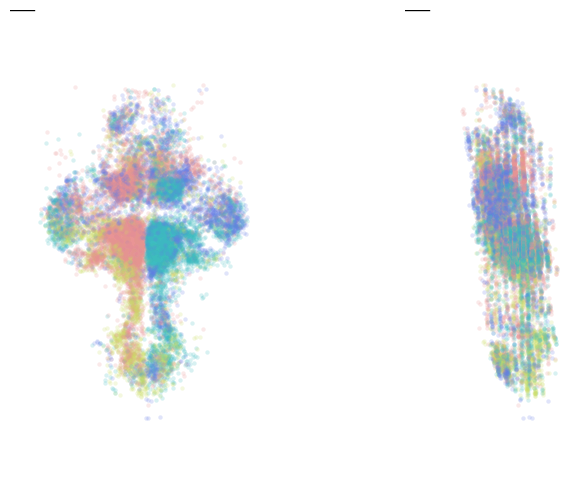

In [25]:
# Visualize cells
fig, ax = plt.subplots(1, 2, figsize=(8, 6), width_ratios=(ref.shape[2], ref.shape[0]))

## Prepare isotropic image axis (without actually showing the reference image, as it gets busy)
# horizontal projection
ax[0].imshow(np.sum(ref, axis=0)*0, cmap='gray_r')
# saggital projection
ax[1].imshow((np.sum(ref, axis=2)).T*0, cmap='gray_r')

## loop through data and do actual scatter plotting
for D in data:
    # We are reordering the optic flow direction, so that directions match with the cyclic color map
    # Left: Red, Forward: Yellow, Right: Green, Back: Blue
    for j, i in enumerate((2,1,3,0)): 
        coords = D['coords']
        inds = D['dscells'][i]
        ax[0].scatter(D['coords'][inds, 0], D['coords'][inds, 1], s=10, alpha=.2, color=cc.cm.CET_C8(j/4))
        ax[1].scatter(D['coords'][inds, 2], D['coords'][inds, 1], s=10, alpha=.2, color=cc.cm.CET_C8(j/4))

# axis management        
for axx in ax:
    axx.set_aspect('equal')
    axx.yaxis.set_inverted(True) 
    axx.axis('off')
    axx.plot((0,50),(0,0),'k-') # 50 micron

# This is saved as a raster as it gets too heavy as vector
plt.savefig('./svgs/Fig6B.png', format='png')
plt.show()

### Fig. 6DE (global mean triggered activity over time and time-averaged of forward tuned cells)

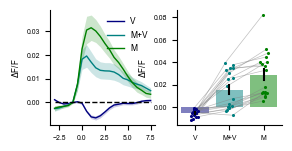

Wilcoxon V vs. M+V p = 1.53e-05
Wilcoxon M+V vs. M p = 7.63e-06


In [28]:
fig, ax = plt.subplots(1, 2, figsize=(3, 1.5))

# Plot over time
for i in range(3):
    plot_mean_sem(ax[0], t_snip, mean_fcell_activity[:, i, :], color=colors[i], label=labels[i])
ax[0].plot(t_snip, t_snip*0, 'k--')
scatter_bar(time_averaged_fcell_activity.T, connect=True, ax=ax[1], color=colors, condnames=labels)
ax[0].legend()
ax[0].set_ylabel('time (s)')

# Plot as a bar
for axx in ax:
    axx.set_ylabel('$\Delta$F/F')
    toggle_spines(axx, 0, 1, 0, 1)
plt.savefig('./svgs/Fig6DE.svg', format='svg')
plt.show()

# run stats
p0 = wilcoxon(time_averaged_fcell_activity[:, 0]-time_averaged_fcell_activity[:, 1])[1]
p1 = wilcoxon(time_averaged_fcell_activity[:, 1]-time_averaged_fcell_activity[:, 2])[1]
print('Wilcoxon V vs. M+V p = {:0.2e}'.format(p0))
print('Wilcoxon M+V vs. M p = {:0.2e}'.format(p1))

### Fig. 6F (mask affiliation of forward tuned cells)
- This looks a bit different from the published version because we binarized the reference stack so it is lighter, just FYI
- Colors indicate:
    - Violet: Pretectum (PT)
    - Red: Inferior Olive (IO)
    - Yellow: Thalamus (Th)
    - Green: Hindbrain (HB)
    - Cyan: Optic Tectum (OT)

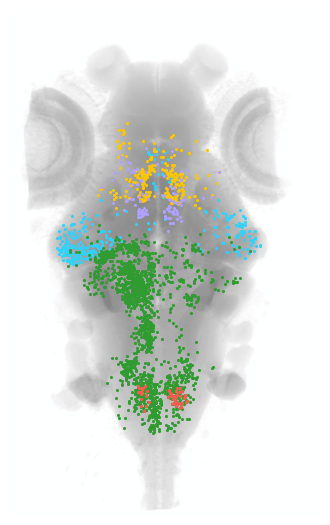

In [32]:
# visualize in-mask ROIs?

fig, ax = plt.subplots(1, 1, figsize=(4,7))

# plot reference
ax.imshow(np.mean(ref, axis=0), zorder=-100, cmap=cc.cm.CET_L1_r, vmax=2)

# plot ROIs
for k, D in enumerate(data):
    is_fcell = D['dscells'][1]
    in_masks = D['in_masks']
    coords = D['coords']
    for j in range(in_masks.shape[1]):
        ax.scatter(coords[is_fcell*in_masks[:,j],0], coords[is_fcell*in_masks[:,j],1], s=5, color=cc.cm.CET_C6s(j/5), zorder=-j)

# axis management
ax.set_aspect('equal')
ax.yaxis.set_inverted(True) 
ax.axis('off')

plt.savefig('./svgs/Fig6F.png', format='png')
plt.show()

### Fig. 6F (region-separated mean triggered activity of forward tuned cells)

PT V vs. M+V vs. M Wilcoxon p = 0.00011 / 0.0079 N = 17 fish that had cells in this mask
IO V vs. M+V vs. M Wilcoxon p = 0.00012 / 0.00043 N = 15 fish that had cells in this mask
Th V vs. M+V vs. M Wilcoxon p = 0.0019 / 7.6e-06 N = 18 fish that had cells in this mask
HB V vs. M+V vs. M Wilcoxon p = 3.8e-05 / 7.6e-06 N = 18 fish that had cells in this mask
OT V vs. M+V vs. M Wilcoxon p = 0.00014 / 0.0066 N = 18 fish that had cells in this mask


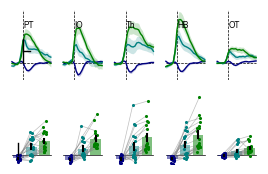

In [34]:
fig, ax = plt.subplots(2, len(masks), figsize=(3.2,2))

# loop through regions
for j in range(len(masks)):
    this_resp = np.asarray(masked_fcell_resp[j])
    for i in range(3):
        plot_mean_sem(ax[0, j], t_snip, this_resp[:, i, :], color=colors[i], label=labels[i])
    temp = np.mean(this_resp[:, :, average_range], axis=2).T
    scatter_bar(temp, connect=True, ax=ax[1,j], color=colors, condnames=labels)
    ax[0, j].text(0, 0.03, mask_names[j])
    toggle_spines(ax[0, j], 0, 0, 0, 0)
    toggle_spines(ax[1, j], 0, 0, 0, 0)
    
    ax[0, j].plot(t_snip, t_snip*0, 'k--', zorder=-10, lw=0.5)
    ax[0, j].plot((0,0), (-0.015, 0.045), 'k--', zorder=-10, lw=0.5)
    ax[1, j].plot((-0.5,2.5), (0,0), 'k-', zorder=-10, lw=0.5)
    
    ax[0, j].set_ylim([-0.015, 0.045])
    ax[1, j].set_ylim([-0.015, 0.1])
    
    # show stats
    print(mask_names[j] + ' V vs. M+V vs. M Wilcoxon p = {:0.2} / {:0.2} N = {} fish that had cells in this mask'.format(wilcoxon(temp[0,:]-temp[1,:])[1],wilcoxon(temp[2,:]-temp[1,:])[1], temp.shape[1]))

# scale bars
ax[0, 0].plot((0,0), (0,0.02), 'k-') 
ax[0, 0].plot((0,2), (0.01,0.01), 'k-')
ax[1, 0].plot((0,0), (0,0.02), 'k-')
    
plt.savefig('./svgs/Fig6F.svg', format='svg')
plt.show()

### Fig. S6A (Example fish that showed direction selective responses to probe without swimming much)

In [35]:
fid = 12
D = data[fid]

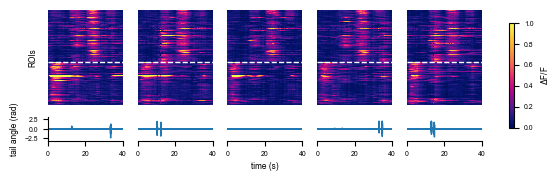

In [36]:
# reconstitute relevant time vectors etc
probe_duration = (D['slog'][0]['on_duration'] + D['slog'][0]['off_duration']) * D['slog'][0]['n_directions']
probe_snip_ind = np.arange(int(probe_duration * D['fr']))
probe_t = probe_snip_ind / D['fr']

# figure out when probe was happening on the behavior tracking time axis
probe_onset_t = D['t_s'][np.where(np.diff((D['probe_direction']==1).astype(int))==1)[0]]
is_probe_b = [(D['t_b']>this_t)*(D['t_b']<(this_t+probe_duration))  for this_t in probe_onset_t]

fig, ax = plt.subplots(2, 5, height_ratios=(4,1), figsize=(7,1.7))

# Plot ROI activities
for i, axx in enumerate(ax[0]):
    f_snip = D['probe_snip'][np.where(D['dscells'][1])[0], :, i]
    b_snip = D['probe_snip'][np.where(D['dscells'][0])[0], :, i]
    n_cell = f_snip.shape[0] + b_snip.shape[0]
    im = axx.imshow(np.vstack((f_snip, b_snip)),aspect ='auto',
               interpolation='none', extent=(0, probe_duration, n_cell, 0),
               vmin=0.0, vmax=1.0, cmap=cc.cm.CET_L8)
    axx.plot([0, probe_duration],[f_snip.shape[0],f_snip.shape[0]],'w--')
    toggle_spines(axx, 0, 0, 0, 0)
cb = plt.colorbar(im, ax=ax, location='right', shrink=0.8)
cb.set_label('$\Delta$F/F')

# Plot tail traces
for i, axx in enumerate(ax[1]):
    this_t = D['t_b'][is_probe_b[i]]
    axx.plot(this_t - this_t[0], D['tail_sum'][is_probe_b[i]])
    axx.set_ylim([-np.pi, np.pi])
    axx.set_xlim([0, probe_duration])
    toggle_spines(axx, 0, 1, 0, i==0)
    
ax[0, 0].set_ylabel('ROIs')
ax[1, 0].set_ylabel('tail angle (rad)')
ax[1, 2].set_xlabel('time (s)')

plt.savefig('./svgs/FigS6A.svg', format='svg')
plt.show()

### Fig. S6B (Distribution of motor correlation and sensory response reliability)
- The message is the same as S6A, that visual stimuli explain the cell responses better than the swimming

In [37]:
# create binned heatmap
cell_label = np.sum(np.asarray(D['dscells']) * np.asarray([1,2,3,4])[:, None], axis=0) #b, f, l, r
hists = np.zeros((5, 20, 20))
for D in data:
    cell_type_as_int = np.sum(np.asarray(D['dscells']) * np.asarray([1,2,3,4])[:, None], axis=0)
    for i in range(5):
        hists[i, :, :] += np.histogram2d(D['probe_corr'][cell_type_as_int==i],
                                         D['probe_motor_r'][cell_type_as_int==i],
                                         bins=np.linspace(-1,1,21))[0]

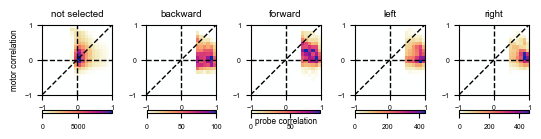

In [38]:
# plot heatmap per cell type

fig, ax= plt.subplots(1,5, figsize=(6.5,1.3))
cell_labels = ('not selected', 'backward', 'forward', 'left', 'right')

for i, axx in enumerate(ax):
    im = axx.imshow(hists[i, :, :].T, extent=(-1,1,1,-1), cmap=cc.cm.CET_L17)
    plt.colorbar(im, ax=axx, location='bottom', shrink=0.8)
    axx.set_title(cell_labels[i])
    axx.set_xlim([-1,1])
    axx.set_ylim([-1,1])
    axx.set_xticks([-1,0,1])
    axx.set_yticks([-1,0,1])
    axx.plot([-1,1],[0,0],'k--')
    axx.plot([0,0],[-1,1],'k--')
    axx.plot([-1,1],[-1,1],'k--')
ax[0].set_ylabel('motor correlation')
ax[2].set_xlabel('probe correlation')

plt.savefig('./svgs/FigS6B.svg', format='svg')
plt.show()

### Fig. S6C (Individual cell triggered responses from an example fish)
- The goal is to show that the kind of average traces shown in Fig. 6D-F do not result from averaging different kinds of cells

In [39]:
fid = 6
D = data[fid]

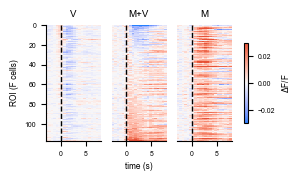

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(3.0, 1.5))
vmax= 0.03
sort_ind = np.argsort(D['mean_triggered_dff'][1][D['dscells'][1]])
N = np.sum(D['dscells'][1])

for i in range(3):
    # show sorted triggered response
    im = ax[i].imshow(np.mean(D['triggered_dff'][i][D['dscells'][1], :, :][sort_ind, :, :], axis=2),
                 aspect='auto', interpolation='none', extent=(-pre_duration,post_duration,N,0),
                 vmax=vmax, vmin=-vmax, cmap=cc.cm.CET_D9)
    ax[i].plot((0,0),(0,N), 'k--')
    ax[i].set_title(labels[i])
    toggle_spines(ax[i], 0, 1, 0, i==0)
ax[0].set_ylabel('ROI (F cells)')
ax[1].set_xlabel('time (s)')
cb = plt.colorbar(im, ax=ax, location='right', shrink=0.7)
cb.set_label('$\Delta$F/F')

plt.savefig('./svgs/FigS6C.svg', format='svg')
plt.show()

### Fig. S6D (Quantification of reafference signal from an example fish)
- Most of the time, motor signals overcompensated visually triggered dips

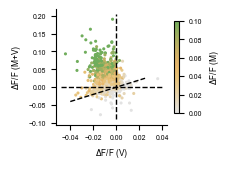

In [41]:
vmax = 0.1
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5))

# scatter plot of V vs. M+V, colored by M
for D in data:
    inds = D['dscells'][1]
    resp = D['mean_triggered_dff']
    sc = ax.scatter(resp[0][inds], resp[1][inds],
                    c=resp[2][inds], s=5, vmax=vmax, vmin=0, cmap=cc.cm.CET_L11_r)
ax.plot([0,0],ax.get_ylim(), 'k--')
ax.plot(ax.get_xlim(), [0,0], 'k--')
ax.plot([-0.04,0.025], [-0.04,0.025], 'k--')
cb = plt.colorbar(sc, ax=ax, location='right', shrink=0.8)
toggle_spines(ax,0,1,0,1)
ax.set_xlabel('$\Delta$F/F (V)')
ax.set_ylabel('$\Delta$F/F (M+V)')
cb.set_label('$\Delta$F/F (M)')

plt.savefig('./svgs/FigS6D.svg', format='svg')
plt.show()

### Fig. S6E (Motor responses over anatomical space)
- Because the scale of resposnes, in general, is different in each cell
- As such, we normalize the motor triggered activity (M) by the amplitude of their sensory responses in the probe

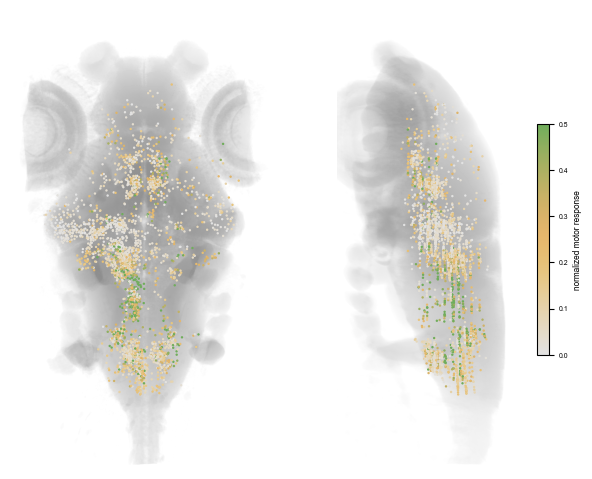

In [50]:
vmax = 0.5
fig, ax = plt.subplots(1, 2, figsize=(8, 6), width_ratios=(ref.shape[2], ref.shape[0]))

# Show the reference
ax[0].imshow(np.mean(ref, axis=0),   cmap='gray_r', vmax=2, zorder=-100)
ax[1].imshow(np.mean(ref, axis=2).T, cmap='gray_r', vmax=2, zorder=-100)

# loop over recordings
masked_mean_vmr = []
for k, D in enumerate(data):
    resp = D['mean_triggered_dff'] # tuple of ROI x time x repetition array
    is_fcell = D['dscells'][1]
    fcoords = D['coords'][is_fcell, :]
    
    # normalize motor response by probe sensory amplitude
    sensory_amplitude = np.percentile(np.mean(D['probe_snip'], axis=2), 90, axis=1)
    v_m_ratio = resp[2] / sensory_amplitude
    
    # show ROIs colored by normalized motor response
    sc = ax[0].scatter(fcoords[:, 0], fcoords[:, 1], s=3, c=v_m_ratio[is_fcell], vmin=0, vmax=vmax, cmap=cc.cm.CET_L11_r)
    ax[1].scatter(fcoords[:, 2], fcoords[:, 1], s=3,  c=v_m_ratio[is_fcell], vmin=0, vmax=vmax, cmap=cc.cm.CET_L11_r)
    
    # average for each mask, for later bar plot visualization
    in_masks = D['in_masks']
    masked_mean_vmr.append([np.mean(v_m_ratio[is_fcell*m]) for m in in_masks.T])
masked_mean_vmr = np.asarray(masked_mean_vmr)

# colorbar
cb = plt.colorbar(sc, ax=ax, location='right', shrink=0.5)
cb.set_label('normalized motor response')

# axis management
for axx in ax:
    axx.set_aspect('equal')
    axx.yaxis.set_inverted(True) 
    axx.axis('off')
    
plt.savefig('./svgs/FigS6Ep.png', format='png')
plt.show()

### Fig. S6F (by region mean normalized motor response)

Friedman for by-region difference p = 6.52e-06


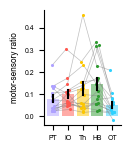

In [52]:
fig, ax = plt.subplots(1,1, figsize=(1.0,1.5))
non_nan_mmvmr = masked_mean_vmr[~np.any(np.isnan(masked_mean_vmr), axis=1),:].T
scatter_bar(non_nan_mmvmr, connect=True, color=[cc.cm.CET_C6s(j/5) for j in range(5)], 
            ax=ax, condnames=mask_names)
ax.set_ylabel('motor-sensory ratio')
toggle_spines(ax, 0, 1, 0, 1)
print('Friedman for by-region difference p = {:0.2e}'.format(friedmanchisquare(*non_nan_mmvmr)[1]))
plt.savefig('./svgs/FigS6F.svg', format='svg')
plt.show()

### Fig. S6GH (global mean triggered activity over time and time-averaged of *backward* tuned cells)
- Here, we find that even backward tuned cells can get positive bout-related activity, which is not consistent with reafference cancellation

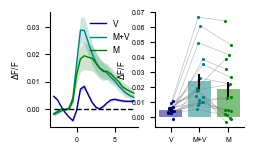

Wilcoxon V vs. M+V p = 7.63e-06
Wilcoxon M+V vs. M p = 6.58e-03


In [54]:
fig, ax = plt.subplots(1, 2, figsize=(2.5, 1.5))

# over time
for i in range(3):
    plot_mean_sem(ax[0], t_snip, mean_bcell_activity[:, i, :], color=colors[i], label=labels[i])
ax[0].plot(t_snip, t_snip*0, 'k--')
ax[0].legend()
ax[0].set_ylabel('time (s)')

# as bars
scatter_bar(time_averaged_bcell_activity.T, connect=True, ax=ax[1], color=colors, condnames=labels)

# axis management
for axx in ax:
    axx.set_ylabel('$\Delta$F/F')
    toggle_spines(axx, 0, 1, 0, 1)
plt.savefig('./svgs/FigS6GH.svg', format='svg')
plt.show()

# runs stats
p0 = wilcoxon(time_averaged_bcell_activity[:, 0]-time_averaged_bcell_activity[:, 1])[1]
p1 = wilcoxon(time_averaged_bcell_activity[:, 1]-time_averaged_bcell_activity[:, 2])[1]
print('Wilcoxon V vs. M+V p = {:0.2e}'.format(p0))
print('Wilcoxon M+V vs. M p = {:0.2e}'.format(p1))

### Fig. S6I (bout negative backward cell anatomical distribution)
- Even though on average backward tuned cells exhibit positive bout-related related activity (inconsistent with reafference cancellation), if we look for them, there are bout-negative backward-tuned cells.

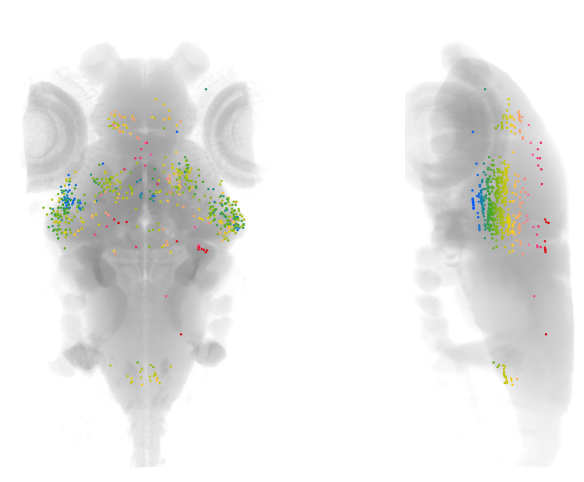

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), width_ratios=(ref.shape[2], ref.shape[0]))

# show reference
ax[0].imshow(np.mean(ref, axis=0), cmap='gray_r', vmax=2, zorder=-100)
ax[1].imshow(np.mean(ref, axis=2).T, cmap='gray_r', vmax=2, zorder=-100)

# search & plot bout-negative backward-tuned cells
bnbc_snip = []
for k, D in enumerate(data):
    resp = D['triggered_dff'] # tuple of ROI x time x repetition array
    is_bcell = D['dscells'][0]
    is_bout_negative = np.mean(resp[2][:, (t_snip>0)*(t_snip<4)], axis=(1,2)) < 0
    bnbc_coords = D['coords'][is_bcell * is_bout_negative, :]
    sc = ax[0].scatter(bnbc_coords[:, 0], bnbc_coords[:, 1], s=3, c=bnbc_coords[:, 2], vmin=150, vmax=300, cmap=cc.cm.CET_R3)
    sc = ax[1].scatter(bnbc_coords[:, 2], bnbc_coords[:, 1], s=3, c=bnbc_coords[:, 2], vmin=150, vmax=300, cmap=cc.cm.CET_R3)
    
    # look at the time course
    if any (is_bcell * is_bout_negative):
        bnbc_snip.append(np.asarray([np.mean(temp[is_bcell * is_bout_negative, :, :], axis=(0,2)) for temp in resp]))

# prepare bout negative backward cell responses (for later plots)
bnbc_snip = np.asarray(bnbc_snip)
time_averaged_bnbc_activity = np.mean(bnbc_snip[:, :, average_range], axis=2)
        
for axx in ax:
    axx.set_aspect('equal')
    axx.yaxis.set_inverted(True) 
    axx.axis('off')
    
plt.savefig('./svgs/FigS6I.png', format='png')
plt.show()

### Fig. S6J (there are more bout negative backward cells than forward cells)
- The point is that the sign of motor-related modulation does show some preference consistent with reafference cancellation

forward vs. backward cells, bout negative fraction. wilcoxon p = 1.07e-04


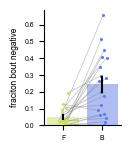

In [62]:
bnf = [] # bout negative fraction
for k, D in enumerate(data):
    resp = D['triggered_dff'] # tuple of ROI x time x repetition array

    is_bcell = D['dscells'][0]
    is_fcell = D['dscells'][1]

    bout_negative_frac = (np.mean(np.mean(resp[2][is_fcell,:][:, (t_snip>0)*(t_snip<3)], axis=(1,2)) < 0),
                          np.mean(np.mean(resp[2][is_bcell,:][:, (t_snip>0)*(t_snip<3)], axis=(1,2)) < 0))
    bnf.append(bout_negative_frac)
bnf = np.asarray(bnf)

fig, ax = plt.subplots(1,1,figsize=(1, 1.5))
p = scatter_bar(bnf.T, connect=True, ax=ax, color=(cc.cm.CET_C8s(0.5), cc.cm.CET_C8s(1.0)))
ax.set_xticks((0,1))
ax.set_xticklabels(('F','B'))
ax.set_ylabel('fraciton bout negative')
toggle_spines(ax, 0, 1, 0, 1)

# print stats
print('forward vs. backward cells, bout negative fraction. wilcoxon p = {:0.2e}'.format(p[0,1]))

plt.savefig('./svgs/FigS6J.svg', format='svg')
plt.show()

### FIg. S6KL (bout negative backward cell response over time and averaged over time)

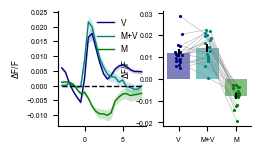

Wilcoxon V vs. M+V p = 9.84e-02
Wilcoxon M+V vs. M p = 1.53e-05


In [64]:
fig, ax = plt.subplots(1, 2, figsize=(2.5, 1.5))

# over time
for i in range(3):
    plot_mean_sem(ax[0], t_snip, bnbc_snip[:, i, :], color=colors[i], label=labels[i])
ax[0].plot(t_snip, t_snip*0, 'k--')
ax[0].legend()
ax[0].set_ylabel('time (s)')

# bar plot
scatter_bar(time_averaged_bnbc_activity.T, connect=True, ax=ax[1], color=colors, condnames=labels)


for axx in ax:
    axx.set_ylabel('$\Delta$F/F')
    toggle_spines(axx, 0, 1, 0, 1)
plt.savefig('./svgs/FigS6KL.svg', format='svg')
plt.show()

# run stats
p0 = wilcoxon(time_averaged_bnbc_activity[:, 0]-time_averaged_bnbc_activity[:, 1])[1]
p1 = wilcoxon(time_averaged_bnbc_activity[:, 1]-time_averaged_bnbc_activity[:, 2])[1]
print('Wilcoxon V vs. M+V p = {:0.2e}'.format(p0))
print('Wilcoxon M+V vs. M p = {:0.2e}'.format(p1))